In [1]:
%matplotlib notebook

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

<hr style="border-width:4px; border-color:coral"/>

# List of examples

<hr style="border-width:4px; border-color:coral"/>

In [3]:
ex_list = ['star_center_32']

example = ex_list[0]

compare_list = ['Matlab','FISHPACK']

<hr style="border-width:4px; border-color:coral"/>

## Set up comparison timing data

<hr style="border-width:4px; border-color:coral"/>

### Create DataFrame for Matlab timing data 
* Run example 'laplace.m' in '/Users/calhoun/projects/HPS/code/matlab/HPS_solve'

   * Creates matrix for 2d Laplace equation   
   * solves Laplace's Equation: uleft = uright = 1; ubottom = utop = 0;   
   * MATLAB backslash uses UMFPACK

### Create DataFrame for Fishpack timing data

* Run example 'test_hwscrt2' in '/Users/calhoun/try/tst_hwscrt2/test_hwscrt'

    * Choose mode 2 (accuracy and timing)
    * Example 1





In [4]:
# -------------------------------------
# Set up DataFrame for comparison data                                                      
# --------------------------------------
idx = pandas.IndexSlice

cols = ['N','walltime','Rate','DOF/s']
eff_res = [32, 64, 128, 256, 512, 1024, 2048, 4096]

solver = compare_list

iterables = [solver, eff_res]

index = pandas.MultiIndex.from_product(iterables,names=['Solver','Eff. Res'])
df_compare = pandas.DataFrame(index=index,columns=cols).sort_index()

cols = ['N','walltime','Rate','DOF/s']

# ----------------------
# Add other data                                               
# ----------------------
fname_dir = 'timing_data'
for n,s in enumerate(solver):
    fname_results = os.path.join('{:s}'.format(fname_dir),
                         '{:s}'.format(s),
                         'results.out')
    df_other = pandas.read_table(fname_results,delim_whitespace=True)
    wall_rate = np.log2(df_other['walltime'].values[0:-1]/df_other['walltime'].values[1:])
    dofs = df_other['N']**2/df_other['walltime']

    df_other['Rate'] = np.insert(wall_rate,0,np.nan)
    df_other['DOF/s'] = dofs
    df_compare.loc[idx[solver[n]],:] = df_other[cols].values


# -----------------------------------
# Fix data types for comparison data                                               
# ------------------------------------
Int_type = pandas.Int32Dtype()  # Use this extended type if data contains Nans
int_type = 'int32'
float_type = 'float'
o_type = 'object'

dtypes = {'walltime': float_type,
          'N' : Int_type,
          'Rate' : float_type,
          'DOF/s' : float_type}

for col, dtype in dtypes.items():
    try:
        df_compare[col] = df_compare[col].astype(dtype)
    except:
        print('Not setting {:s} to {:s}'.format(col,dtype))
        pass

# ------------------------
# Display comparison data                                                    
# -------------------------
df = df_compare.loc[idx[:],('walltime','Rate','DOF/s')].unstack(0)
fstr = {('Rate','FISHPACK') : '{:.2f}'.format,
        ('walltime','FISHPACK') : '{:.2e}'.format, 
        ('DOF/s','FISHPACK') : '{:.4e}'.format,
        ('Rate','Matlab') : '{:.2f}'.format,
        ('walltime','Matlab') : '{:.2e}'.format, 
        ('DOF/s','Matlab') : '{:.4e}'.format}

df.style.format(fstr)    # Ignore formatting for some reason

<hr style="border-width:4px; border-color:coral"/>

# Data Tools (file)

<hr style="border-width:4px; border-color:coral"/>

In [5]:
%%file data_tools.py
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

import sys

cmap = plt.get_cmap('tab20').colors

amr_colors = {'advance' : (cmap[0:2]),     # blue
              'ghost'   : (cmap[2:4]),     # orange
              'regrid'  : (cmap[4:6]),     # green
              'comm'    : (cmap[6:8]),     # red
              'memcopy' : (cmap[8:10]),    # purple
              'other'   : (cmap[10:12]),   # brown
              'extra1'  : (cmap[12:14]),   # pink
              'extra2'  : (cmap[14:16]),   # grey
              'extra3'  : (cmap[16:18]),   # light green
              'extra4'  : (cmap[18:20])}   # tourquoise
  
Int_type = pandas.Int32Dtype()  # Use this extended type if data contains Nans
int_type = 'int32'
float_type = 'float'
o_type = 'object'

dtypes = {'walltime': float_type,
          'ell_solve' : float_type,
          'max' : Int_type,
          'mx' : Int_type,
          'ell_grids' : Int_type,
          '1-norm' : float_type,
          '2-norm' : float_type,
          'inf-norm' : float_type,
          'itcount' : Int_type,
          'DOF' : Int_type}


def read_data(dir,ex,mesh,solver):
    fname_results = os.path.join('{:s}'.format(dir),
                         '{:s}'.format(ex),
                         '{:s}'.format(mesh),
                         '{:s}'.format(solver),
                         'results.out')
    # Read errors
    fname_errors = os.path.join('{:s}'.format(dir),
                         '{:s}'.format(ex),
                         '{:s}'.format(mesh),
                         '{:s}'.format(solver),
                         'errors.dat')        
        
    try:
        df = pandas.read_table(fname_results,delim_whitespace=True)
        print("Reading '{:s}'".format(fname_results))
        try:
            df_errors = pandas.read_table(fname_errors,delim_whitespace=True)
        except:
            print("Not able to read '{:s}'".format(fname_errors))
            sys.exit()
    except:
        print("No file '{:s}'".format(fname_results))
        df = None
        fstr = ''
        return df,fstr
        
    # Add a column for effective resolution
    df['eff_res'] = df['mx']*2**df['max']
    df['DOF'] = df['ell_grids']*df['mx']**2
    df.sort_values('eff_res',inplace=True)
    
    df['1-norm'] = df_errors['1-norm'].values
    df['2-norm'] = df_errors['2-norm'].values
    df['inf-norm'] = df_errors['inf-norm'].values
    df['itcount'] = (df_errors['itcount'].values).astype(int)

    
    # Int values are commented out - any NaNs cannot be formatted as an
    # integer type
    f = '{:.2f}'.format
    int_format = '{:.0f}'.format
    fstr = {'p' : int_format,
            'mx' : int_format,  # Needed to avoid Nans
            'max' : int_format,
            'walltime' : f,
            'ell_solve' : f,
            '1-norm' : '{:.2e}'.format,
            '2-norm' : '{:.2e}'.format,
            'inf-norm' : '{:.2e}'.format,
            'DOF' : int_format,
            'itcount' : int_format,
            'eff_res' : int_format,
            'ell_grids' : int_format,
            'DOF' : int_format}
    
    return df,fstr

def convergence_rates(df,field=['1-norm','2-norm','inf-norm'],I=None):
    Neff = df.index.get_level_values(0).values
    for f in field:
        y = df[f].values

        # Plot best-fit speed-up line
        t_errors = np.array(df[f].values)
        if I is None:
            c = np.polyfit(np.log(Neff[:-1]),np.log(t_errors[:-1]),1)
        else:
            c = np.polyfit(np.log(Neff[I[0]:I[1]+1]),np.log(t_errors[I[0]:I[1]+1]),1)

        plt.loglog(Neff,y,'.-',markersize=15,label='{:s} (slope={:6.2f})'.format(f,c[0]))            
        plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k-',linewidth=1)

    p0 = np.log2(Neff[0])
    p1 = np.log2(Neff[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    Nstr = (['{:d}'.format(int(N)) for N in Neff])
    plt.xticks(Neff,Nstr)
        
    plt.legend()
    plt.show()
    

def iteration_count_plot(df,I=None):
    Neff = df.index.get_level_values(2).values
    for f in ['single','uniform','adapt']:
        y = df[f].values

        # Plot best-fit speed-up line
        t_itcount = np.array(df[f].values).astype(float)
        if I is None:
            c = np.polyfit(np.log(Neff[:-1]),np.log(t_itcount[:-1]),1)
        else:
            c = np.polyfit(np.log(Neff[I[0]:I[1]+1]),np.log(t_itcount[I[0]:I[1]+1]),1)

        plt.loglog(Neff,y,'.-',markersize=15,label='{:s} (slope={:6.2f})'.format(f,c[0]))            
        plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k-',linewidth=1)
        #c[0] = -2
        #plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k--',label='Theoretical',linewidth=0.5)

    p0 = np.log2(Neff[0])
    p1 = np.log2(Neff[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    Nstr = (['{:d}'.format(int(N)) for N in Neff])
    plt.xticks(Neff,Nstr)
    
    ax = plt.gca()
    ax.set_ylabel('Iteration Count')
    ax.set_xlabel('Effective Resolution')
    
    plt.legend()
    plt.show()
    
def iteration_count_barplot(df):
    Neff = df.index.get_level_values(2).values
    for f in ['single','uniform','adapt']:
        y = df[f].values

        # Plot best-fit speed-up line
        t_itcount = np.array(df[f].values).astype(float)
        if I is None:
            c = np.polyfit(np.log(Neff[:-1]),np.log(t_itcount[:-1]),1)
        else:
            c = np.polyfit(np.log(Neff[I[0]:I[1]+1]),np.log(t_itcount[I[0]:I[1]+1]),1)

        plt.loglog(Neff,y,'.-',markersize=15,label='{:s} (slope={:6.2f})'.format(f,c[0]))            
        plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k-',linewidth=1)
        #c[0] = -2
        #plt.loglog(Neff,np.exp(np.polyval(c,np.log(Neff))),'k--',label='Theoretical',linewidth=0.5)

    ax = df_plot.plot.barh(width=0.75)
    p0 = np.log2(Neff[0])
    p1 = np.log2(Neff[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    Nstr = (['{:d}'.format(int(N)) for N in Neff])
    plt.xticks(Neff,Nstr)
    
    ax = plt.gca()
    ax.set_ylabel('Iteration Count')
    ax.set_xlabel('Effective Resolution')
    
    plt.legend()
    plt.show()


    
def dof_efficiency(df):


    # Efficiency
    Neff = df.index.get_level_values(2).values

    dofs = df[field]/df['walltime']

    plt.semilogx(Neff,E,'.-',markersize=15)
    plt.semilogx(Neff,[100]*len(Neff),'k--',linewidth=2)

    plt.xlabel('Eff. Resolution',fontsize=16)
    plt.ylabel('Efficiency (%)',fontsize=16)
    plt.title("Efficiency (%)");
    plt.legend(['Time (s)', 'Perfect efficiency'])
    
    Nstr = (['{:d}'.format(int(N)) for N in Neff])
    plt.xticks(Neff,Nstr)
    
    # plt.ylim([10,110])
    plt.grid()
    plt.show()
    
def bar_plot(df_in,field):
    
    Neff = df_in.index.get_level_values(2).values

    df_plot = df_in.copy()
    c = []
    for N in Neff:
        c += ['Neff {:d}'.format(N.astype(int))]        
    #df_plot.columns = reversed(c)

    # ------------------------ Plotting command --------------------------
    ax = df_plot.plot.barh(width=0.75)
    # --------------- Post-processing (legend, axis tick marks) ----------
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right')

    # ax.xaxis.set_major_locator(plt.MultipleLocator(10))   # Multiples of 10  (seconds)
    # ax.xaxis.set_minor_locator(plt.MultipleLocator(5))   # Multiples of 5 (seconds)
    # ax.xaxis.set_major_formatter(plt.FixedFormatter(lambda value,tick_number : '{:.2f}'.format(value)))

    ax.set_yticklabels(Neff)
    ax.set_ylabel('Effective Resolution')
    
    if field is 'ell_solve':
        ax.set_xscale('log')
        plt.xlabel('Time (seconds)');
    elif field is 'itcount':
        plt.xlabel('Iteration count')
    
    plt.grid()
    # plt.xlim([0,135]);
    plt.show()    
    
def barh_plot(df_in):
    
    Neff = df_in.index.get_level_values(0).values

    df = df_in.copy()
    # -------------------------- Pre-processing ----------------------------
    # df['ghost'] = df['ghostfill'] + df['patch_comm']
    #df['Other'] = df['walltime'] - df['advance'] - df['ghostfill'] - df['patch_comm'] \
    #        -df['adapt']-df['regrid']-df['output']


    # di = {'advance' : 'Advance', 'ghost' : 'Ghost'}

    # For plotting (iloc[::-1] reverses order of the rows)
    df_plot = df.iloc[::-1].copy()
    df_plot = df
    c = []
    for N in Neff:
        c += ['Eff. Res. {:d} '.format(N)]
    df_plot.index = reversed(c)
    
    # -------------------------- Plotting command -------------------------
    ax = df_plot.plot.barh(width=0.85,stacked=True)
    
    plt.xlabel('Time (seconds)');

    # --------------------------- Post-processing -------------------------
    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(reversed(handles), reversed(labels), loc='lower right')

    ax.xaxis.set_major_locator(plt.MultipleLocator(10))   # Multiples of 60 (minutes)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))   # Multiples of 60 (minutes)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.2f}'.format(value/60)))

    plt.grid()
    # plt.xlim([0,100]);
    plt.show()    
    


Overwriting data_tools.py


<hr style="border-width:4px; border-color:coral"/>

# Read data and set up Pandas MultiIndex

<hr style="border-width:4px; border-color:coral"/>

In [6]:
import data_tools
import os

idx = pandas.IndexSlice

cols = ['mx','max','walltime','ell_solve','ell_grids','1-norm','2-norm',
        'inf-norm','itcount','DOF'];

mesh = ['single','uniform','adapt']
patch_solver = ['VC']
eff_res = [32,64,128,256,512,1024, 2048,4096]

iterables = [ex_list, mesh,patch_solver,eff_res]

index = pandas.MultiIndex.from_product(iterables,names=['example','mesh',
                                                        'patch-solver','eff_res'])
df = pandas.DataFrame(index=index,columns=cols).sort_index()

dir = 'timing_data'
for ex in ex_list:
    for m in mesh:
        for s in patch_solver:
            dft,fstr = data_tools.read_data(dir,ex,m,s)            
            if dft is not None:
                l = dft['eff_res']
                df.loc[idx[ex,m,s,l],:] = dft[cols].values
    
df.index.name = 'eff_res'
for col, dtype in data_tools.dtypes.items():
    try:
        df[col] = df[col].astype(dtype)
    except:
        print('Not setting {:s} to {:s}'.format(col,dtype))
        pass

# example_data = df.transpose().unstack(level=2).stack(level=0)
example_data = df
df.style.format(fstr)

Reading 'timing_data/star_center_32/single/VC/results.out'
Reading 'timing_data/star_center_32/uniform/VC/results.out'
Reading 'timing_data/star_center_32/adapt/VC/results.out'


<hr style="border-width:4px; border-color:coral"/>

# Practice using a MultiIndex table

<hr style="border-width:4px; border-color:coral"/>

In [7]:
# Extract all of the data for one example

example_data.loc['star_center_32'].style.format(fstr)

In [8]:
# Extract only the 'uniform' mesh results for a particular example

df_uni = example_data.loc[(example,'uniform','VC'),:]
df_uni.style.format(fstr)

,mx,max,walltime,ell_solve,ell_grids,1-norm,2-norm,inf-norm,itcount,DOF
eff_res,,,,,,,,,,
32,32,0,0.02,0.01,1,2.12e+00,3.08e+00,1.44e+01,5,1024
64,32,1,0.06,0.06,4,2.28e+01,3.10e+01,8.21e+01,6,4096
128,32,2,0.17,0.16,16,7.49e+00,1.02e+01,2.93e+01,7,16384
256,32,3,0.56,0.49,64,8.22e-02,1.19e-01,6.70e-01,6,65536
512,32,4,3.13,2.90,256,2.68e-03,3.78e-03,3.06e-02,9,262144
1024,32,5,12.93,12.02,1024,4.97e-05,3.05e-04,5.33e-03,9,1048576
2048,32,6,83.79,80.20,4096,1.23e-05,7.53e-05,1.30e-03,15,4194304
4096,32,7,288.39,273.78,16384,3.08e-06,1.88e-05,3.24e-04,13,16777216


In [9]:
# Extract subset of columns for one example

df_uni = example_data.loc[idx['star_center_32',:,'VC',:],['max','mx','ell_solve','inf-norm']]
df_uni.style.format(fstr)

In [10]:
# Extract all results at effective resolution 256 and 512

example_data.loc[idx[example,:,'VC',(256,512)],:]


mx  max  walltime  ell_solve  \
example        mesh    patch-solver eff_res                                  
star_center_32 adapt   VC           256       32    3   0.54818    0.48698   
                                    512       32    4   2.29360    2.12220   
               single  VC           256      256    0   2.24840    1.87000   
                                    512      512    0  17.14700   15.60300   
               uniform VC           256       32    3   0.55876    0.49191   
                                    512       32    4   3.12790    2.89950   

                                             ell_grids    1-norm    2-norm  \
example        mesh    patch-solver eff_res                                  
star_center_32 adapt   VC           256             52  0.082243  0.118770   
                                    512            148  0.002684  0.003776   
               single  VC           256              1  0.082243  0.118770   
                                    512              1  0.002684  0.003776   
               uniform VC           256             64  0.082243  0.118770   
                                    512            256  0.002684  0.003776   

                                             inf-norm  itcount     DOF  
example        mesh    patch-solver eff_res                             
star_center_32 adapt   VC           256       0.66995        7   53248  
                                    512       0.03062        9  151552  
               single  VC           256       0.66995        9   65536  
                                    512       0.03062        9  262144  
               uniform VC           256       0.66995        6   65536  
                                    512       0.03062        9  262144

In [11]:
# Extract data for one solver type ('VC') and display time for elliptic solve side-by-side

df_mesh = example_data.loc[idx[:,:,'VC',:],'ell_solve']
# unstack level is the level that should be side by side
cols = ['single','uniform','adapt']
df_mesh.unstack(level=1)[cols].style.format('{:.2e}'.format)

In [12]:
# Extract data for one solver type ('VC') and display time for elliptic solve side-by-side

df_mesh = example_data.loc[idx['star_center_32',:,'VC',:],'itcount']
# unstack level is the level that should be side by side
cols = ['single','uniform','adapt']
df_mesh.unstack(level=1)[cols]

mesh                                 single  uniform  adapt
example        patch-solver eff_res                        
star_center_32 VC           32            8        5      5
                            64            8        6      6
                            128           8        7      7
                            256           9        6      7
                            512           9        9      9
                            1024          8        9     13
                            2048          8       15     11
                            4096         10       13      6

In [13]:
# Display with effective resolution across the top

idx = pandas.IndexSlice
cols = ['single','uniform','adapt']
df_effres = example_data.loc[idx[example,:,'VC'],('1-norm')]
# df_effres.unstack().style.format('{:.4e}'.format)
df_effres.unstack().style.format('{:.4e}'.format)

In [14]:
# Select series and extract values of data from individual run

idx = pandas.IndexSlice
s_adapt = example_data.loc[(example,'adapt','VC'),'ell_solve']
[s_adapt.index.values,s_adapt.values]

[array([  32,   64,  128,  256,  512, 1024, 2048, 4096]),
 array([7.4248e-03, 4.2895e-02, 1.7298e-01, 4.8698e-01, 2.1222e+00,
        9.2975e+00, 2.5886e+01, 9.1038e+01])]

In [15]:
# Display using different colors

idx = pandas.IndexSlice
eff_res = [64,128,256,512,1024,2048,4096]    # NaNs in 'adapt' simulation prevent 
df_time = example_data.loc[idx['star_center_32',['uniform','adapt','single'],'VC',eff_res],('ell_solve')].unstack(level=1)
df_time['single/uniform'] = (df_time['single']/df_time['uniform']).astype(float)
df_time['single/adapt'] = (df_time['single']/df_time['adapt']).astype(float)
df_time.style.format('{:.2f}'.format)
df_time.style.format('{:.2f}'.format).background_gradient(subset=['single/uniform','single/adapt'],\
                                  cmap='Reds',low=0.5,high=1)

In [16]:
# Display using different colors

idx = pandas.IndexSlice
eff_res = [32,64,128,256,512,1024]    # NaNs in 'adapt' simulation prevent 
df_time = example_data.loc[idx['star_center_32',:,'VC',eff_res],('ell_solve')].unstack(level=1)
df_time['uniform/single'] = (df_time['uniform']/df_time['single']).astype(float)
df_time['adapt/single'] = (df_time['adapt']/df_time['single']).astype(float)
df_time.style.format('{:.2f}'.format)
df_time.style.format('{:.2f}'.format).background_gradient(subset=['uniform/single','adapt/single'],\
                                  cmap='Oranges',low=0.3,high=1)

In [17]:
# Degrees of freedom processed per second

idx = pandas.IndexSlice
eff_res = [64,128,256,512,1024,2048,4096]    # NaNs in 'adapt' simulation prevent 
df_dof = example_data.loc[idx[:,['uniform','adapt','single'],'VC',eff_res],('DOF')]
df_wall = example_data.loc[idx[:,['uniform','adapt','single'],'VC',eff_res],('ell_solve')]
df_itcount = example_data.loc[idx[:,['uniform','adapt','single'],'VC',eff_res],('itcount')]

df_dofs = df_dof/df_wall

df_dofs.unstack(level=1).style.format('{:.0f}'.format) \
               .background_gradient(subset=['adapt','uniform','single'],\
                                      cmap='Greens',low=0.4,high=1)              

<hr style="border-width:4px; border-color:coral"/>

# Convergence rates

<hr style="border-width:4px; border-color:coral"/>

Create data frame containing convergence rates. 

In [18]:
# Compute convergence rates for uniform method and put them into a data frame

ex = 'star_center_32'
mesh = 'adapt'
eff_res = [64,128,256,512,1024,2048,4096] 

# Set up Data frame
idx = pandas.IndexSlice
df_rates = example_data.loc[idx[ex,mesh,'VC',:],
                          ['1-norm','2-norm','inf-norm']]

# use numpy arrays to create convergence rates
r1 = np.log2(df_rates['1-norm'].values[0:-1]/df_rates['1-norm'].values[1:])
r2 = np.log2(df_rates['2-norm'].values[0:-1]/df_rates['2-norm'].values[1:])
r3 = np.log2(df_rates['inf-norm'].values[0:-1]/df_rates['inf-norm'].values[1:])

# Add rates to data frame; pre-pend with Nan value
df_rates['rate (1)'] = np.insert(r1,0,np.nan)
df_rates['rate (2)'] = np.insert(r2,0,np.nan)
df_rates['rate (inf)'] = np.insert(r3,0,np.nan)

# Format columns of data frame
fstr = {}.fromkeys(['1-norm', '2-norm', 'inf-norm'], '{:.2e}'.format)
fstr.update(fstr.fromkeys(['rate (1)', 'rate (2)', 'rate (inf)'], '{:.2f}'.format))

# Display data frame
df_rates.style.format(fstr)

<IPython.core.display.Javascript object>


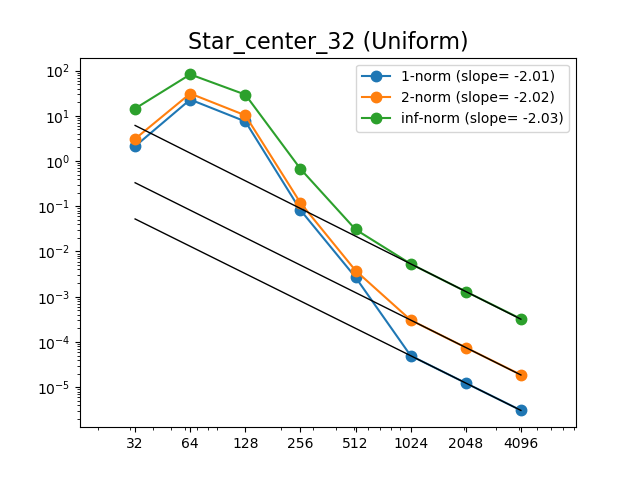

In [19]:
import data_tools

ex = 'star_center_32'
cols = ['1-norm','2-norm','inf-norm']

df_vc = example_data.loc[(ex,'single','VC'),cols]

plt = data_tools.plt

plt.figure()
data_tools.convergence_rates(df_vc,['1-norm','2-norm','inf-norm'],[5,6])
plt.title('{:s} (Uniform)'.format(ex.capitalize()),fontsize=16);

<hr style="border-width:4px; border-color:coral"/>

## Timing : Bar plot (VC)

<hr style="border-width:4px; border-color:coral"/>

<IPython.core.display.Javascript object>


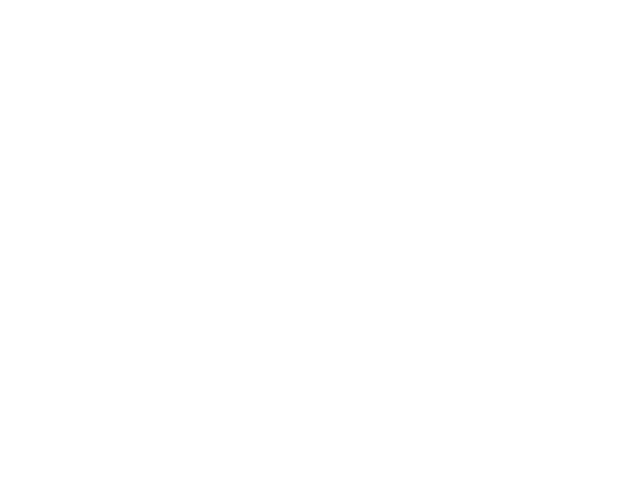

<IPython.core.display.Javascript object>


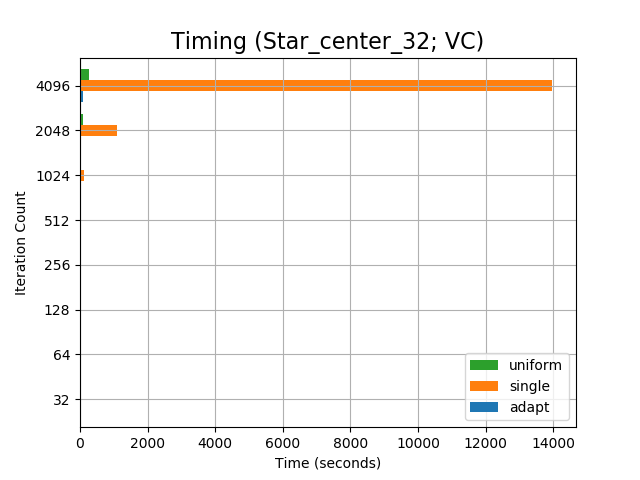

In [20]:
import data_tools
plt = data_tools.plt
plt.figure()

ex = 'star_center_32'
field = 'ell_solve'
df_vc = example_data.loc[idx[ex,['uniform','adapt','single'],'VC',:],field]
df_vc = pandas.DataFrame(df_vc.unstack(1))

h = data_tools.bar_plot(df_vc,field)

plt = data_tools.plt
ax = plt.gca()
plt.title('Timing ({:s}; VC)'.format(ex.capitalize()),fontsize=16);

# plt.xlim([5e-3,6.5e2]);
# ax.set_xscale('log')


## Iteration count : Bar plot (VC)

<IPython.core.display.Javascript object>


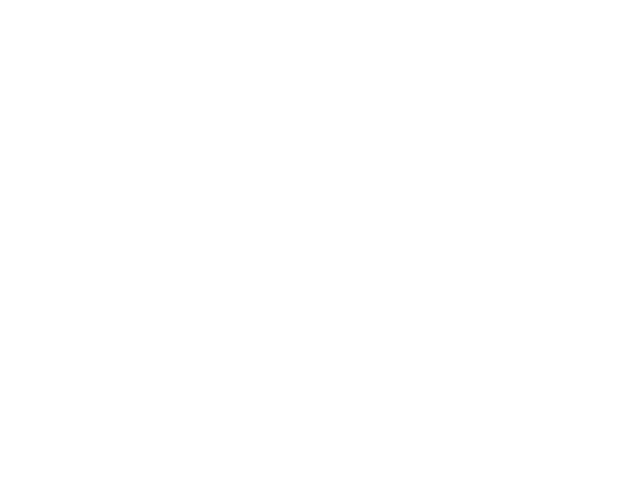

<IPython.core.display.Javascript object>


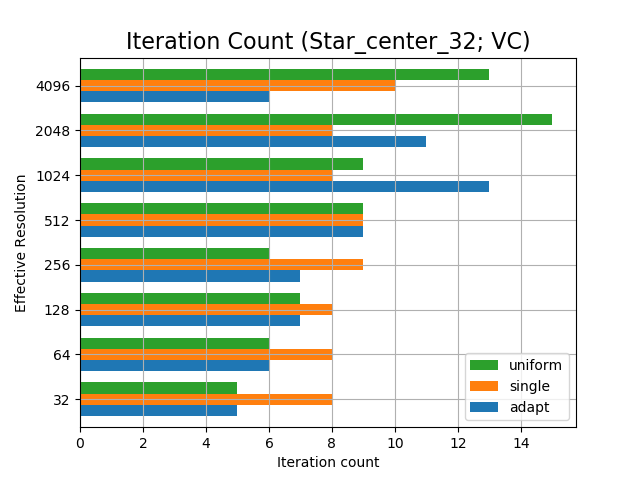

In [21]:
import data_tools

plt = data_tools.plt
plt.figure()

df_vc = example_data.loc[idx[ex,['uniform','single','adapt'],'VC',:],'itcount']
df_vc = pandas.DataFrame(df_vc.unstack(1))


h = data_tools.bar_plot(df_vc,'itcount')

plt = data_tools.plt
ax.set_xscale('linear')
ax.set_ylabel('Iteration Count')

data_tools.plt.title('Iteration Count ({:s}; VC)'.format(example.capitalize()),fontsize=16);

<IPython.core.display.Javascript object>


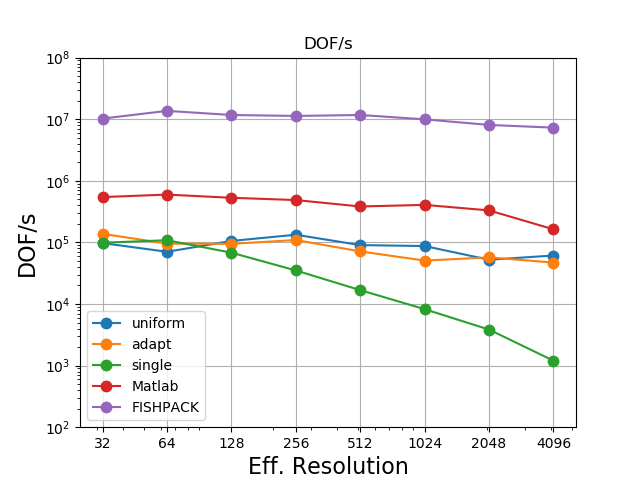

In [22]:
import data_tools

plt = data_tools.plt

plt.figure()

plot_efficiency = False

df = example_data.loc[idx['star_center_32',:,'VC']]

cols = ['uniform','adapt','single']

def plot_dofs(Neff,dofs,label):
    if plot_efficiency:
        m = dofs.argmax()
        E = 100*dofs/dofs[m]            
        plt.semilogx(Neff,E,'.-',markersize=15,label=label)
    else:
        plt.semilogx(Neff,dofs,'.-',markersize=15,label=label)    

# Efficiency
for c in cols:
    df_wall = df.loc[idx[c],'ell_solve']
    df_dof = df.loc[idx[c],'DOF']
    Neff = df_wall.index.values
    dofs = df_dof.values/df_wall.values
    plot_dofs(Neff,dofs,c)
    
# ----------------------------------
# Add comparison data
# ----------------------------------
solver = compare_list

for s in solver:
    df_other = df_compare.loc[idx[s]]
    df_wall = df_other['walltime']
    df_dofs = df_other['DOF/s']
    Neff = df_wall.index.values
    dofs = df_dofs.values
    plot_dofs(Neff,dofs,s)

# ----------------------------------
# Adjust axes
# ----------------------------------
plt.xlabel('Eff. Resolution',fontsize=16)
if plot_efficiency:
    plt.semilogx(Neff,[100]*len(Neff),'k--',linewidth=2)
    plt.ylabel('Efficiency (%)',fontsize=16)
    plt.title("Efficiency (%)")
    plt.ylim([0,110])
else:
    plt.ylabel('DOF/s',fontsize=16)
    plt.title("DOF/s");
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.1e}'.format(value)))
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e2,1e8])

Nstr = (['{:d}'.format(int(N)) for N in Neff])
plt.xticks(Neff,Nstr)

plt.legend()
plt.grid()
plt.show()

<hr style="border-width:4px; border-color:coral"/>

# Comparisons between patch sizes

<hr style="border-width:4px; border-color:coral"/>

In [ ]:
import data_tools
from data_tools import amr_colors

idx = pandas.IndexSlice

# ---------------------------------- bar plots ---------------------------------------

df_time = example_data.loc[idx[:,'adapt','VC',:],('ell_grids','itcount','ell_solve')]
df_time = df_time.unstack(0)  # .style.format({'ell_solve' : '{:.2f}'.format})
Neff = df_time.index.get_level_values(2).values

plt = df_time['ell_solve'].plot.barh()    # width,color=amr_colors['ghost'][0])

plt.set_yticklabels(Neff)
plt.set_ylabel('Effective Resolution')
plt.set_xscale('log')

plt.set_title('Timing (Adapt; VC)',fontsize=16);